In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from scipy.stats import ttest_ind
from functools import reduce

In [2]:
df = pd.read_excel("QVI_data.xlsx")

In [3]:
df.dtypes

LYLTY_CARD_NBR               int64
DATE                datetime64[ns]
STORE_NBR                    int64
TXN_ID                       int64
PROD_NBR                     int64
PROD_NAME                   object
PROD_QTY                     int64
TOT_SALES                  float64
PACK_SIZE                    int64
BRAND                       object
LIFESTAGE                   object
PREMIUM_CUSTOMER            object
dtype: object

# Monthly analysis

In [4]:
df['YEARMONTH'] = df['DATE'].dt.to_period('M').astype(str).str.replace('-', '')

In [5]:
monthly = df.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxn=('TXN_ID', 'nunique'),
    totQty=('PROD_QTY', 'sum')
).reset_index()

In [6]:
monthly['avgtxncustom']=monthly['nTxn']/monthly['nCustomers']
monthly['avgprice']=monthly['totSales']/monthly['totQty']

In [7]:
print(monthly.head())

   STORE_NBR YEARMONTH  totSales  nCustomers  nTxn  totQty  avgtxncustom  \
0          1    201807     206.9          49    52      62      1.061224   
1          1    201808     176.1          42    43      54      1.023810   
2          1    201809     278.8          59    62      75      1.050847   
3          1    201810     188.1          44    45      58      1.022727   
4          1    201811     192.6          46    47      57      1.021739   

   avgprice  
0  3.337097  
1  3.261111  
2  3.717333  
3  3.243103  
4  3.378947  


# Calculate similarity to select control store

In [21]:
def calculate_correlation(df, metric_col, trial_store):
    results = []
    stores = df['STORE_NBR'].unique()
    for store in stores:
        if store == trial_store:
            continue
        trial_series = df[df['STORE_NBR'] == trial_store][metric_col].values
        compare_series = df[df['STORE_NBR'] == store][metric_col].values
        if len(trial_series) == len(compare_series):
            corr = pd.Series(trial_series).corr(pd.Series(compare_series))
            results.append({
                'Trial': trial_store,
                'otherS': store,
                'corr_measure': corr
            })
    return pd.DataFrame(results)

In [25]:
def calculate_magnitude_distance(df, metric_col, trial_store):
    results = []
    stores = df['STORE_NBR'].unique()
    
    trial_vals = df[df['STORE_NBR'] == trial_store][metric_col].values
    
    for store in stores:
        if store == trial_store:
            continue
        
        compare_vals = df[df['STORE_NBR'] == store][metric_col].values
        
        if len(trial_vals) == len(compare_vals):
            distance = abs(trial_vals - compare_vals)
            normalized = 1 - ((distance - distance.min()) / (distance.max() - distance.min()))
            magnitude_score = normalized.mean()
            
            results.append({
                'Trial': trial_store,
                'otherS': store,
                'mag_measure': magnitude_score
            })
    
    return pd.DataFrame(results)


In [81]:
metrics = ['totSales', 'nCustomers']
trial_stores = [77, 86, 88]
merged_all = []

for trial in trial_stores:
    metric_scores = []

    for metric in metrics:
        corr_df = calculate_correlation(monthly, metric, trial)
        corr_df.rename(columns={'Store1': 'Trial', 'Store2': 'otherS'}, inplace=True)

        mag_df = calculate_magnitude_distance(monthly, metric, trial)
        mag_df.rename(columns={'Store1': 'Trial', 'Store2': 'otherS'}, inplace=True)

        merged = pd.merge(corr_df, mag_df, on=['Trial', 'otherS'])
        merged[f'{metric}_score'] = (merged['corr_measure'] + merged['mag_measure']) / 2

        metric_scores.append(merged[['Trial', 'otherS', f'{metric}_score']])

    merged_metric = reduce(lambda left, right: pd.merge(left, right, on=['Trial', 'otherS']), metric_scores)

    merged_metric['final_score'] = merged_metric[[f'{m}_score' for m in metrics]].mean(axis=1)

    merged_all.append(merged_metric)

final_df = pd.concat(merged_all, ignore_index=True)

best_control_stores = (
    final_df.sort_values(by='final_score', ascending=False)
    .groupby('Trial')
    .first()
    .reset_index()
)

control_mapping = dict(zip(best_control_stores['Trial'], best_control_stores['otherS']))
print("📋 Final control store:", control_mapping)


📋 Final control store: {77: 233, 86: 229, 88: 188}


Best control store will be {77: 233, 86: 229, 88: 188}

# Test 

In [73]:
control_mapping = {
    77: 233,
    86: 229,
    88: 188
}

In [74]:
pre_trial = [f"{y}{m:02d}" for y in range(2018, 2019 + 1) for m in range(1, 13)]
pre_trial = [m for m in pre_trial if '201807' <= m <= '201901']

trial_period = ['201902', '201903', '201904']

In [75]:
monthly['YEARMONTH'] = monthly['YEARMONTH'].astype(str)

In [76]:
def plot_sales(trial_store, control_store):
    subset = monthly[(monthly['STORE_NBR'].isin([trial_store, control_store]))]
    subset = subset[subset['YEARMONTH'].astype(str).isin(pre_trial + trial_period)]
    print(subset.head())
    print(subset['YEARMONTH'].unique())
    for store in [trial_store, control_store]:
        store_data = subset[subset['STORE_NBR'] == store]
        plt.plot(store_data['YEARMONTH'], store_data['totSales'], label=f"Store {store}")

    plt.axvline('201902', color='gray', linestyle='--')
    plt.title(f"Sales Comparison: Trial {trial_store} vs Control {control_store}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

     STORE_NBR YEARMONTH  totSales  nCustomers  nTxn  totQty  avgtxncustom  \
880         77    201807     296.8          51    55      84      1.078431   
881         77    201808     255.5          47    48      74      1.021277   
882         77    201809     225.2          42    44      70      1.047619   
883         77    201810     204.5          37    38      52      1.027027   
884         77    201811     245.3          41    44      67      1.073171   

     avgprice  
880  3.533333  
881  3.452703  
882  3.217143  
883  3.932692  
884  3.661194  
['201807' '201808' '201809' '201810' '201811' '201812' '201901' '201902'
 '201903' '201904']


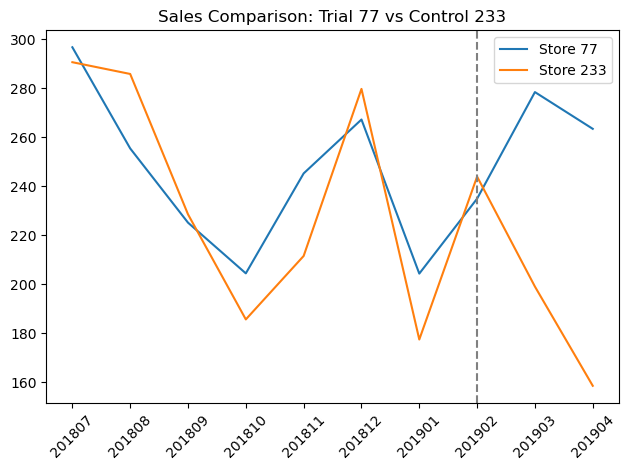

In [77]:
plot_sales(77, 233)

     STORE_NBR YEARMONTH  totSales  nCustomers  nTxn  totQty  avgtxncustom  \
977         86    201807    892.20          99   126     251      1.272727   
978         86    201808    764.05          94   110     215      1.170213   
979         86    201809    914.60         103   128     258      1.242718   
980         86    201810    948.40         109   138     276      1.266055   
981         86    201811    918.00         100   125     254      1.250000   

     avgprice  
977  3.554582  
978  3.553721  
979  3.544961  
980  3.436232  
981  3.614173  
['201807' '201808' '201809' '201810' '201811' '201812' '201901' '201902'
 '201903' '201904']


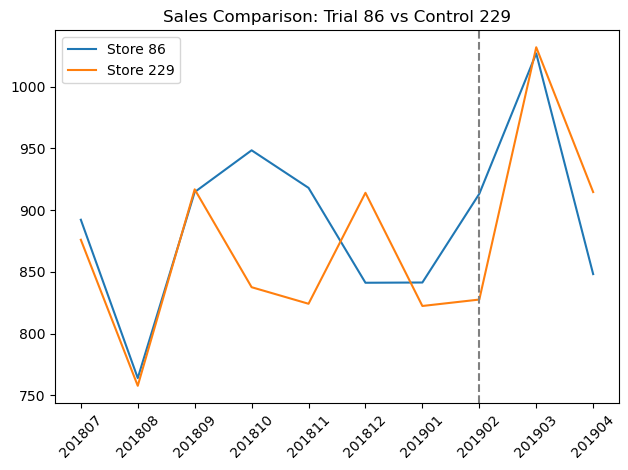

In [78]:
plot_sales(86, 229)

      STORE_NBR YEARMONTH  totSales  nCustomers  nTxn  totQty  avgtxncustom  \
1001         88    201807    1310.0         129   153     306      1.186047   
1002         88    201808    1323.8         131   158     303      1.206107   
1003         88    201809    1423.0         124   157     318      1.266129   
1004         88    201810    1352.4         123   155     316      1.260163   
1005         88    201811    1382.8         130   156     314      1.200000   

      avgprice  
1001  4.281046  
1002  4.368977  
1003  4.474843  
1004  4.279747  
1005  4.403822  
['201807' '201808' '201809' '201810' '201811' '201812' '201901' '201902'
 '201903' '201904']


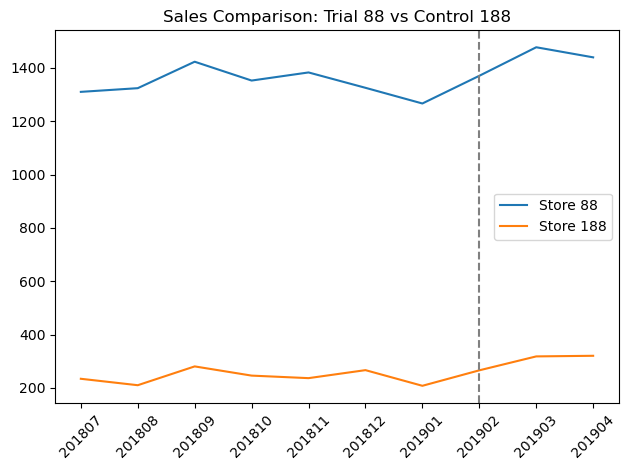

In [79]:
plot_sales(88, 188)

Purpose of t-test is to judge the effect of strategy, so if p-value > 0.05, then difference betweem two stores is not meaningful and otherwise, it is meaningful. The result of t-test shows that the values of two stores is different meaningfully after strategy.

In [80]:
for trial, control in control_mapping.items():
    trial_sales = monthly[(monthly['STORE_NBR'] == trial) & 
                          (monthly['YEARMONTH'].isin(trial_period))]['totSales']
    control_sales = monthly[(monthly['STORE_NBR'] == control) & 
                            (monthly['YEARMONTH'].isin(trial_period))]['totSales']
    
    t_stat, p_val = ttest_ind(trial_sales, control_sales, equal_var=False)
    print(f"Store {trial} vs {control} → t: {t_stat:.2f}, p: {p_val:.4f}")

Store 77 vs 233 → t: 2.10, p: 0.1261
Store 86 vs 229 → t: 0.06, p: 0.9551
Store 88 vs 188 → t: 31.29, p: 0.0000


- The results tell us that only 88 vs 188 is meaningful(p<0.05), but in graph, difference in sales of two stores is already too big. This means we cannot use store 188 as control store.
- p-value of 86 vs 229 > 0.05, difference is not meaningful. This means their strategy is not effective. We can use this as control store because in graph, they are similar.
- 77 vs 233, their p-value is 0.12 > 0.05. But it is not clearly big and strategy is bit effective. In graph, they looks similar. This store is not enough to select as control store.